In [ ]:
!pip3 install git+https://github.com/j6k4m8/nonprofit_networks

In [1]:
from nonprofit_networks import ProPublicaClient
from nonprofit_networks.utils import deep_dict_access
import pandas as pd
import random
import numpy as np


In [2]:
N = 500

random.seed(0)
np.random.seed(0)

In [3]:
client = ProPublicaClient()

In [ ]:
sample_of_nonprofits = client.sample_from_irs_indices(N, years=[2023])
filings = []
for i, nonprofit_ein in enumerate(sample_of_nonprofits.EIN):
    try:
        filing_data = client.get_full_filing(nonprofit_ein, year=2023, as_json=True)
        if filing_data is not None:
            filings.append(filing_data)
    except Exception as e:
        continue
    frac = ((i / N) * 100)
    bar_length = 50
    filled_length = int(frac / 100 * bar_length)
    bar = '#' * filled_length + ' ' * (bar_length - filled_length)
    print(f"\rProgress: [{bar}] {frac:.1f}%", end="")
print("")
print(f"Retrieved {len(filings)} filings from {N} nonprofits.")

Progress: [################################################# ] 99.8%Retrieved 493 filings from 500 nonprofits.


In [5]:
import matplotlib.pyplot as plt

net_assets = []
pct_public_support = []
total_public_support = []
for filing in filings:
    try:
        # Return.ReturnData.IRS990.NetAssetsOrFundBalancesEOYAmt
        this_net_assets = float(
            deep_dict_access(
                filing,
                "Return.ReturnData.IRS990.NetAssetsOrFundBalancesEOYAmt",
                raise_keyerror=True,
            )
        )
        this_pct_public_support = float(
            deep_dict_access(
                filing,
                "Return.ReturnData.IRS990ScheduleA.PublicSupportCY170Pct",
                raise_keyerror=True,
            )
        )
        this_total_public_support = float(
            deep_dict_access(
                filing,
                "Return.ReturnData.IRS990ScheduleA.PublicSupportTotal170Amt",
                raise_keyerror=True,
            )
        )
    except KeyError as e:
        # print(f"KeyError encountered: {e} for filing {filing}")
        continue
    except ValueError as e:
        # print(f"ValueError encountered: {e} for filing {filing}")
        continue

    net_assets.append(this_net_assets)
    pct_public_support.append(this_pct_public_support)
    total_public_support.append(this_total_public_support)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'NetAssets': net_assets,
    'PublicSupportPct': pct_public_support,
    'TotalPublicSupport': total_public_support
})

# Cleanup:
# * remove zeros
# * remove negative net assets
df = df[df['NetAssets'] > 0]
df = df[df["PublicSupportPct"] > 0]


In [6]:
def format_dollar_amt(x):
    """Format a number as a dollar amount."""
    ks = ["", "K", "M", "B"]
    magnitude = 0
    while abs(x) >= 1000 and magnitude < len(ks) - 1:
        magnitude += 1
        x /= 1000.0
    return "${:,.0f}{}".format(x, ks[magnitude])

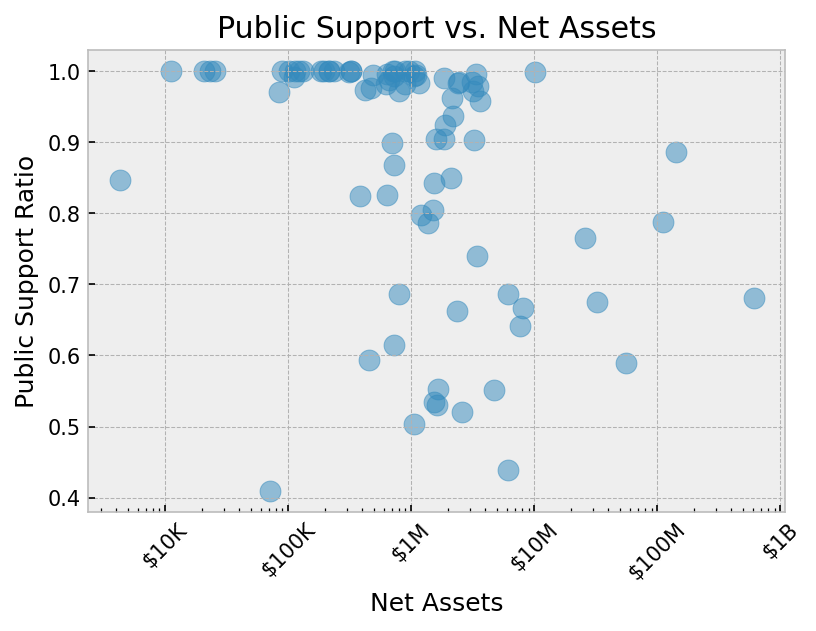

In [7]:
with plt.style.context("bmh"):
    plt.figure(figsize=(6, 4), dpi=150)
    plt.title("Public Support vs. Net Assets")
    plt.xlabel("Net Assets")
    plt.ylabel("Public Support Ratio")
    plt.xscale("log")
    # plt.yscale("log")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(lambda x, p: format_dollar_amt(x))
    plt.grid(True)
    plt.scatter(df.NetAssets, df.PublicSupportPct, alpha=0.5, s=100)
    # plt.yticks([5e-1, 8e-1, 1e0], ["50%", "80%", "100%"])
    plt.show()